# 机器学习实现NBA比赛预测
## 项目介绍
本次项目的任务是基于往年的 NBA 的各项比赛统计数据，实现针对2018-2019年每场比赛，预测比赛中哪支队伍最终将会获胜，并和真实值进行比较。
## 项目流程分析
* 获取数据、分析数据
* 构建出每场比赛的特征表达，即训练样本
* 建立模型，进行模型训练
* 利用模型进行预测

## 参考数据集
数据来源：https://www.basketball-reference.com/

2018-2019Team Per Game Stats.csv：每支队伍在每场比赛中的表现统计。各字段含义如下：
![图片](数据含义.jpeg)
2018-2019Opponent Per Game Stats.csv：每支队伍在每场比赛中遇到的对手表现统计。各字段含义同上。

2018-2019Miscellaneous Stats.csv：每支队伍的综合统计数据。各字段含义如下：
![图片](数据含义2.jpeg)

2018-2019_result.csv：每场比赛的数据。其中包括三个字段：
* WTeam: 比赛胜利队伍
* LTeam: 失败队伍
* WLoc: 胜利队伍一方所在的为主场或是客场

2019-2020_schedule.csv：比赛的安排。其中包括两个字段：
* Vteam: 客场作战队伍
* Hteam: 主场作战队伍


## 读取数据

In [1]:
import pandas as pd
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import random

Mstat = pd.read_csv('2018-2019Miscellaneous Stats.csv')
Ostat = pd.read_csv('2018-2019Opponent Per Game Stats.csv')
Tstat = pd.read_csv('2018-2019Team Per Game Stats.csv')
result_data = pd.read_csv('2018-2019_result.csv')

## 构建特征向量即训练数据
项目的整体目标为针对某一场比赛，根据比赛双方的以往比赛情况判断胜利方，以及可胜概率。为提高预测率，可加入两支队伍各自的Elo等级分（也是由每支队伍以往比赛结果计算得出）作为特征向量的一部分。因此构建的训练样本由两支队伍的以往比赛统计情况（Tstat、Ostat和Mstat表）和两个队伍各自的 Elo 等级分构成。

In [2]:
#首先处理前三张表的数据，进行数据剪枝和数据合并
#丢弃与球队实力无关的统计量
new_Mstat = Mstat.drop(['Rk', 'Arena'], axis=1)
new_Ostat = Ostat.drop(['Rk', 'G', 'MP'], axis=1)
new_Tstat = Tstat.drop(['Rk', 'G', 'MP'], axis=1)
# 将三张表中数据通过相同的index：team合并为一个数据
team_stats1 = pd.merge(new_Mstat, new_Ostat, how='left', on='Team')
team_stats1 = pd.merge(team_stats1, new_Tstat, how='left', on='Team')
#将team作为index
team_stats =team_stats1.set_index('Team', inplace=False, drop=True)

### 计算每支队伍的elo等级分

### elo值介绍

Elo等级分最初用于国际象棋，现在很多的竞技运动或者游戏中都会采用该制度对选手或玩家进行等级划分。
计算公式如下：
假设 A 和 B 的当前等级分为 $R_{A}$ 和 $R_{B}$，则 A 对 B 的胜率期望值为：

$E_{A}=\frac{1}{1+10^{(R_{B}-R_{A})/400}}$

B 对 A 的胜率期望值为:

$E_{B}=\frac{1}{1+10^{(R_{A}-R_{B})/400}}$

如果棋手 A 在比赛中的真实得分 $S_{A}$​（胜 1 分，和 0.5 分，负 0 分）和他的胜率期望值 $E_{A}$​​不同，则他的等级分要根据以下公式进行调整：

$R_{A}^{new}= R_{A}^{old}+K(S_{A}-R_{A}^{old})$

根据等级分的不同 K 值也会做相应的调整：
* 大于等于2400，K=16
* 2100~2400 分，K=24
* 小于等于2100，K=32

In [3]:
base_elo = 1600  # 初始化elo值
team_elos = {}
def get_elo(team):
    try:
        return team_elos[team]
    except:
        # 当最初没有elo时，给每个队伍最初赋base_elo
        team_elos[team] = base_elo
        return team_elos[team]

def calc_elo(win_team, lose_team):
    # winteam, loseteam的输入应为字符串
    # 给出当前两个队伍的elo分数
    winner_rank  = get_elo(win_team)
    loser_rank = get_elo(lose_team)
    # 计算比赛后的等级分，参考elo计算公式
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    # 根据rank级别修改K值
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    # 更新 rank 数值
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_loser_rank = round(loser_rank + (k * (0 - odds)))
    return new_winner_rank, new_loser_rank

### 形成最终训练数据

In [4]:
print("Building data set..")
X = []
y=[]
skip = 0
for index, row in result_data.iterrows():
    Wteam = row['WTeam']
    Lteam = row['LTeam']
    #获取最初的elo或是每个队伍最初的elo值
    team1_elo = get_elo(Wteam)
    team2_elo = get_elo(Lteam)
    # 给主场比赛的队伍加上100的elo值
    if row['WLoc'] == 'H':
        team1_elo += 100
    else:
        team2_elo += 100
    # 把elo当为评价每个队伍的第一个特征值
    team1_features = [team1_elo]
    team2_features = [team2_elo]
    # 添加我们从basketball reference.com获得的每个队伍的统计信息
    for key, value in team_stats.loc[Wteam].iteritems():
        team1_features.append(value)
    for key, value in team_stats.loc[Lteam].iteritems():
        team2_features.append(value)
    # 将两支队伍的特征值随机的分配在每场比赛数据的左右两侧
    # 并将对应的0/1赋给y值
    if random.random() > 0.5:
        X.append(team1_features + team2_features)
        y.append(0)
    else:
        X.append(team2_features + team1_features)
        y.append(1)
    if skip == 0:
        print('X',X)
        skip = 1
    # 根据这场比赛的数据更新队伍的elo值
    new_winner_rank, new_loser_rank = calc_elo(Wteam, Lteam)
    team_elos[Wteam] = new_winner_rank
    team_elos[Lteam] = new_loser_rank
X=np.nan_to_num(X);

Building data set..
X [[1600, 26.4, 51.0, 31.0, 48.0, 34.0, 2.7, -0.44, 2.25, 112.6, 110.0, 2.6, 101.6, 0.312, 0.342, 0.574, 0.532, 12.9, 24.5, 0.241, 0.512, 11.1, 78.6, 0.206, 838342.0, 20447.0, 41.7, 91.5, 0.455, 10.3, 30.0, 0.342, 31.4, 61.5, 0.511, 18.8, 24.5, 0.768, 10.0, 33.5, 43.5, 23.4, 7.7, 4.1, 12.7, 22.1, 112.5, 41.5, 88.2, 0.471, 10.8, 30.2, 0.359, 30.7, 58.0, 0.529, 21.2, 27.5, 0.771, 10.9, 36.9, 47.8, 26.9, 7.4, 5.3, 14.9, 21.3, 115.2, 1700, 25.7, 49.0, 33.0, 52.0, 30.0, 4.44, -0.54, 3.9, 112.2, 107.8, 4.4, 99.6, 0.215, 0.381, 0.567, 0.534, 11.5, 21.6, 0.173, 0.514, 13.4, 77.0, 0.198, 763584.0, 18624.0, 39.5, 88.1, 0.448, 11.5, 33.5, 0.344, 28.0, 54.6, 0.513, 17.4, 22.8, 0.764, 10.4, 35.5, 45.9, 23.7, 6.8, 3.9, 15.1, 19.5, 108.0, 42.1, 90.5, 0.465, 12.6, 34.5, 0.365, 29.5, 56.0, 0.527, 15.6, 19.5, 0.802, 9.8, 34.7, 44.5, 26.3, 8.6, 5.3, 12.8, 20.4, 112.4]]


## 模型训练和预测
比赛结果预测是一个典型的二分类问题。选取逻辑回归进行训练。

In [5]:
from sklearn import linear_model
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

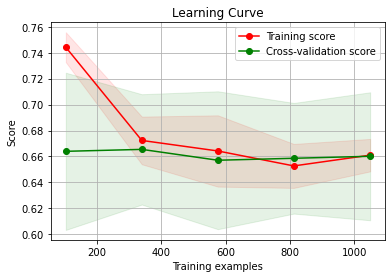

In [6]:
#展示学习曲线
import scikitplot as skplt
skplt.estimators.plot_learning_curve(model, X, y)
plt.show()

In [7]:
# 利用10折交叉验证计算训练正确率
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1).mean())

0.6714954892435808


In [ ]:
# 利用训练好的model在19-20年的比赛中进行预测
result = []
sum=0
count=0
for index, row in schedule1617.iterrows():
    team1 = row['Vteam']
    team2 = row['Hteam']
    pred = predict_winner(team1, team2, model)
    prob = pred[0][0]
    if prob > 0.5:
        winner = team1
        loser = team2
        result.append([winner, loser, prob])
        # if row['V-PTS']>row['H-PTS']:
        #     count=count+1
    else:
        winner = team2
        loser = team1
        result.append([winner, loser, 1 - prob])
        # if row['V-PTS']<row['H-PTS']:
        #     count=count+1
    # sum=sum+1

In [ ]:
#将预测结果写入文件中
with open('19-20_Result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['win', 'lose', 'probability'])
    writer.writerows(result)
    print('done.')
# print(count/sum)